## DSCI 552 PS 4
### Bias and Fair Models - Predicting Happiness 

Each row of the dataset is a REGION

• **Id2 which gives the Region Id,**

• **totalGroup1 is the number of people in ethnic group 1,**

• **totalGroup2 is the number of people in ethnic group 2,**

• **percent_bachelorPlus is the percentage of population with at least a bachelor’s degree**

• **households_meanIncome gives us the mean income per household in the region and**

• **meanvalence gives us the mean happiness in the region**


Correlation between the predicted outcome and independent predictors can be used as a proxy for
measuring fairness. Our goal is to ensure that valence predictions are not biased towards one of
the ethnic group variables. We define protected variables as ones along which biases can be
observed in the outcome. In our case, these are – totalGroup1 and (or) totalGroup2. Your analysis
report should consist of the following four models.”

1. Ground Truth Model – Generate correlations and scatterplots of ground truth valence
with respect to percent_bachelorPlus and households_meanIncome with each of the
scatterplots conditioned on totalGroup1 and totalGroup2. From the scatterplots state
whether you see a bias to one ethnic group? Describe why you think so.
The prediction models are considered fair if the correlations and scatter plot of predicted outcome
vs independent variables conditioned on ethnic group variables are similar to that of ground truth
model.

2. Ethnic Group Aware Model (Prediction Model I) – Build a linear regression model using
all predictors, on a percentage of the data provided. Predict the valence on the entire dataset.
Analyze fairness of predicted valence by comparing the correlations and scatterplots of
Group Aware Model with Ground Truth Model. Report your observations on the
comparison and state if there is bias to one of the two groups when the predicted valence
threshold is set to 5.8.

3. Ethnic Group Blind Model (Prediction Model II) – Build a linear regression model
without using totalGroup1 and totalGroup2 as predictors, on a percentage of the data
provided. Predict the valence on the entire dataset. Analyze fairness of predicted valence
by comparing the correlations and scatterplots of Group Blind Model with Ground Truth
Model. Report your observations on the comparison. Does hiding these protected variables
change the bias identified in the previous model change here? Describe either way.

4. Fair Model – Our R&D team has published a paper on debiasing linear models (available
at: https://arxiv.org/pdf/1910.12854.pdf). On the basis of this work, we have written two
helper functions that you have to use in order to debias the outcome variable. The python
file consisting of these helper functions are available in fair_var.py.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## data preparation and analysis
import pandas as pd 
from pandas.plotting import scatter_matrix
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import scipy as sp 
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import sklearn
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

## modeling
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LassoLars
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from fair_var import *

In [2]:
## import custom function to get feature names
from helper import get_feature_names

In [3]:
df = pd.read_csv(r'../data/chirper-happiness.csv')
print(df.shape)

(2110, 6)


In [4]:
df.head(3)

,Id2,totalGroup1,totalGroup2,percent_bachelorPlus,meanvalence,households_meanIncome
0,6037101110,1244,2319,19.4,5.863903,68938
1,6037101122,304,2175,27.2,5.963174,120490
2,6037101210,2434,2078,16.6,5.623312,54481


In [5]:
df.describe()

,Id2,totalGroup1,totalGroup2,percent_bachelorPlus,meanvalence,households_meanIncome
count,2.110000e+03,2110.000000,2110.000000,2110.000000,2110.000000,2110.000000
mean,6.037379e+09,1607.534597,988.572038,28.824028,5.828721,78324.632227
std,2.057889e+05,1097.976544,995.119185,20.642709,0.113931,43137.269798
min,6.037101e+09,16.000000,1.000000,0.000000,5.110000,9040.000000
25%,6.037206e+09,695.750000,169.000000,11.400000,5.761016,50404.000000
50%,6.037402e+09,1450.000000,636.500000,23.500000,5.822492,67437.500000
75%,6.037541e+09,2368.750000,1587.500000,42.875000,5.889826,92943.000000
max,6.037930e+09,5976.000000,5929.000000,84.200000,6.941389,387177.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2110 entries, 0 to 2109
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id2                    2110 non-null   int64  
 1   totalGroup1            2110 non-null   int64  
 2   totalGroup2            2110 non-null   int64  
 3   percent_bachelorPlus   2110 non-null   float64
 4   meanvalence            2110 non-null   float64
 5   households_meanIncome  2110 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 99.0 KB


# EDA, Data Cleaning, and Transforming steps
We should clean data by: fill missing vals (median imputation), scale the datasets, remove outliers, and do one-hot encoding for categorical vars.

In [7]:
df.isnull().sum()

Id2                      0
totalGroup1              0
totalGroup2              0
percent_bachelorPlus     0
meanvalence              0
households_meanIncome    0
dtype: int64

In [8]:
df.drop(columns=['Id2'], inplace=True)

In [9]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
cat_cols = df.select_dtypes(include=['object']).columns
print(num_cols)

Index(['totalGroup1', 'totalGroup2', 'percent_bachelorPlus', 'meanvalence',
       'households_meanIncome'],
      dtype='object')


In [10]:
## Normalize data
min_max_scaler = MinMaxScaler()
nums_scaled = pd.DataFrame(min_max_scaler.fit_transform(df[num_cols]))
nums_scaled.columns = num_cols

## Outlier removal: get indicies of outlier locations
outlier_locs = []
for col in num_cols:
    curr = df[col]
    mean, std = np.mean(curr), np.std(curr)
    cut_off = std * 3
    lower, upper = mean - cut_off, mean + cut_off
    # print(col, lower, upper)  
    for idx, val in curr.items():
        if val < lower or val > upper:
            outlier_locs.append(idx)
            
outliers = list(set(outlier_locs))

## df2 is just df without the outliers
# df2 = df.drop(df.index[outliers])

# nums_scaled2 = nums_scaled.drop(nums_scaled.index[outliers])

df2 = nums_scaled.drop(nums_scaled.index[outliers])
print(df.shape, df2.shape)

(2110, 5) (2021, 5)


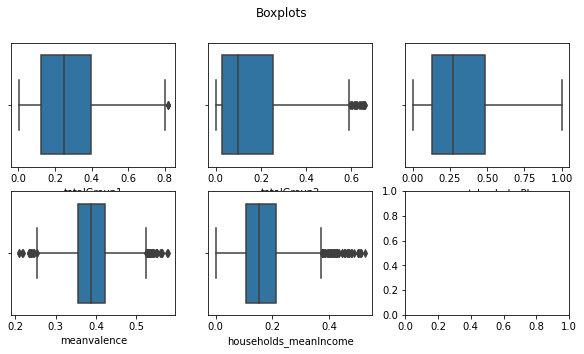

In [11]:
# ## boxplots for numerical vars
fig, axes = plt.subplots(2, 3, sharex = False, figsize=(10,5))
fig.suptitle('Boxplots')

for i, var in enumerate(num_cols):
    if i < 3:
        row = 0
    elif i >= 3: 
        row = 1
    col = i % 3
    
#     sns.boxplot(ax=axes[row,col], data=df, x=var) # skewed
    sns.boxplot(ax=axes[row,col], data=df2, x=var)
# plt.savefig('images/boxplots_1.png')

Text(0.5, 1.0, 'Distribution of households_meanIncome')

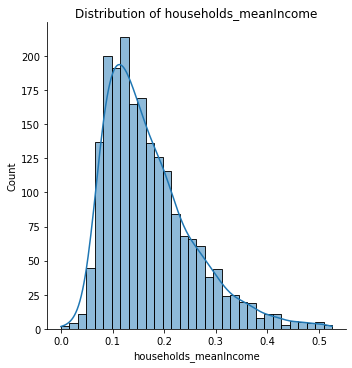

<Figure size 720x432 with 0 Axes>

In [12]:
var = 'households_meanIncome'
# g = sns.displot(data=df, x=var, kde=True)  # skewed
g = sns.displot(data=df2, x=var, kde=True)
plt.figure(figsize=(10,6))
# g.fig.subplots_adjust(top=.95)
g.ax.set_title("Distribution of " + var)
# plt.savefig('../images/PS_1/price_histogram.png')

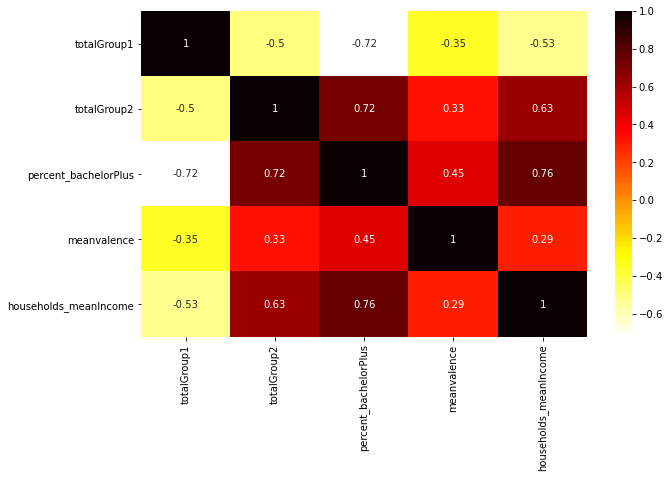

In [14]:
# # ## View correlations btwn features
plt.figure(figsize=(10,6))
sns.heatmap(df2.corr(), annot=True, cmap="hot_r")
plt.savefig('../images/heatmap_1.png')

1. Ground Truth Model – Generate correlations and scatterplots of ground truth valence
with respect to percent_bachelorPlus and households_meanIncome with each of the
scatterplots conditioned on totalGroup1 and totalGroup2. From the scatterplots state
whether you see a bias to one ethnic group? Describe why you think so

In [15]:
sns.set(rc={'figure.figsize':(10, 8)})

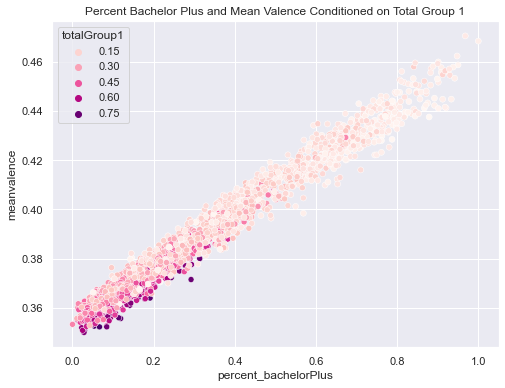

In [65]:
# scatterplot of valence and perc bp
plt.title('Percent Bachelor Plus and Mean Valence Conditioned on Total Group 1')
sns.scatterplot(data=pred_results, x="percent_bachelorPlus", y="meanvalence", hue="totalGroup1", palette='RdPu')
plt.savefig('../images/scatter_1_ethnic_aware_ps4.png')

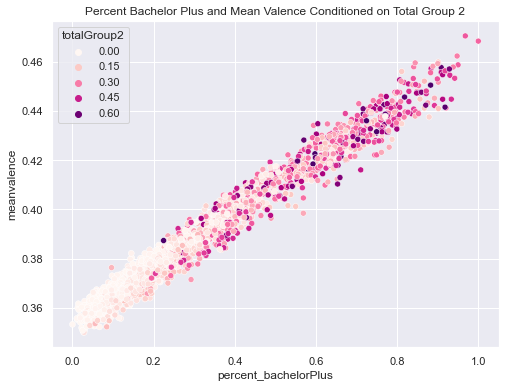

In [66]:
plt.title('Percent Bachelor Plus and Mean Valence Conditioned on Total Group 2')
sns.scatterplot(data=pred_results, x="percent_bachelorPlus", y="meanvalence", hue="totalGroup2", palette='RdPu')
plt.savefig('../images/scatter_2_ethnicaware_ps4.png')

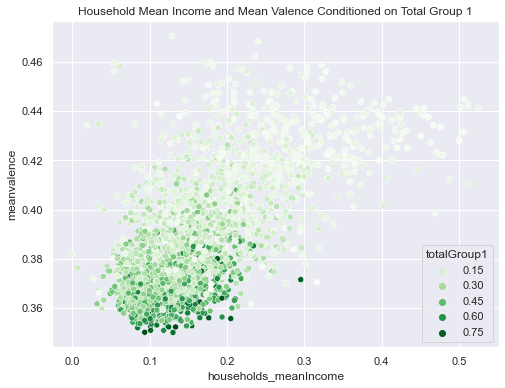

In [67]:
# scatterplot of valence and households mean income
plt.title('Household Mean Income and Mean Valence Conditioned on Total Group 1')
sns.scatterplot(data=pred_results, x='households_meanIncome', y="meanvalence", hue="totalGroup1", palette='Greens')
plt.savefig('../images/scatter_3_ethnicaware_ps4.png')

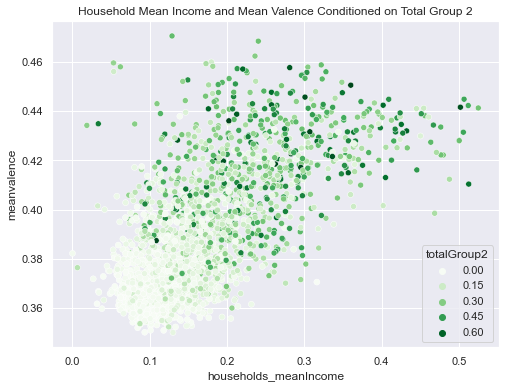

In [70]:
plt.title('Household Mean Income and Mean Valence Conditioned on Total Group 2')
sns.scatterplot(data=pred_results, x='households_meanIncome', y="meanvalence", hue="totalGroup2", palette='Greens')
plt.savefig('../images/scatter_4_ethnicaware_ps4.png')

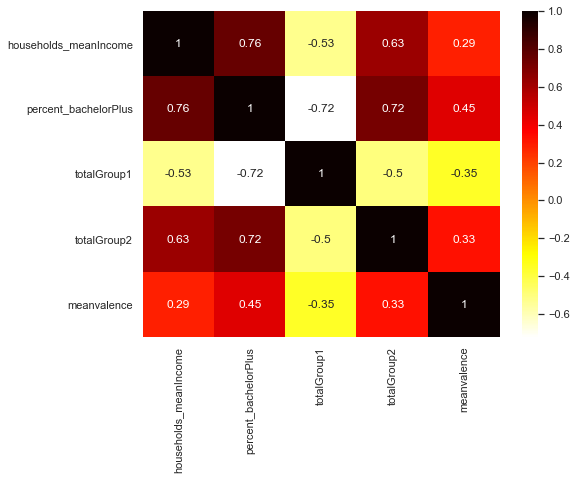

In [69]:
## corrplot
sns.set(rc={'figure.figsize':(8,6)})
cols = ["households_meanIncome","percent_bachelorPlus", "totalGroup1", "totalGroup2", "meanvalence"]
sns.heatmap(df2[cols].corr(), annot=True, cmap="hot_r")
plt.savefig('../images/heatmap_1_ps4.png')

# Lin Regression Modeling 
#### 2. Ethnic Group Aware Model (Prediction Model I)
Build a linear regression model using all predictors, on a percentage of the data provided. Predict the valence on the entire dataset.
Analyze fairness of predicted valence by comparing the correlations and scatterplots of
Group Aware Model with Ground Truth Model. Report your observations on the
comparison and state if there is bias to one of the two groups when the predicted valence
threshold is set to 5.8. **adjust the value by scaling it**

In [16]:
## Transformation Pipeline
df3 = df2.drop(['meanvalence'],axis=1)
df3.head()

,totalGroup1,totalGroup2,percent_bachelorPlus,households_meanIncome
0,0.206040,0.391026,0.230404,0.158403
1,0.048322,0.366734,0.323040,0.294734
2,0.405705,0.350371,0.197150,0.120171
3,0.082718,0.230938,0.235154,0.113292
4,0.058557,0.525472,0.368171,0.216570


In [17]:
## Split in train/test/valid
X = df3.to_numpy()
y = df2['meanvalence'].to_numpy()
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

(2021, 4) (2021,)
(1616, 4) (405, 4)


In [18]:
vifs = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(len(vifs))
## NOTE: any VIF > 4 needs investigation for possible multicollinearity!
print(sorted(vifs)[::-1])

4
[11.334944325873385, 10.666083810882371, 4.309564594360372, 1.9684631279068046]


In [19]:
n = X.shape[0]  ## sample size
p = X.shape[1]  ## num of predictors

In [20]:
## OLS Linear Reg Model - using sm
X_train_df = pd.DataFrame(X_train, columns=df3.columns)

# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model = sm.OLS(y_train, X0_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.201
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     101.4
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           4.27e-77
Time:                        14:09:27   Log-Likelihood:                 2515.9
No. Observations:                1616   AIC:                            -5022.
Df Residuals:                    1611   BIC:                            -4995.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3654      0.005     68.186      0.000       0.355       0.376
totalGroup1              -0.0132      0.010     -1.279      0.201      -0.033       0.007
totalGroup2               0.0059      0.012      0.494      0.621      -0.018       0.029
percent_bachelorPlus      0.1182      0.012     10.147      0.000       0.095       0.141
households_meanIncome    -0.0661      0.024     -2.792      0.005      -0.113      -0.020
==============================================================================
Omnibus:                       40.224   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.954
Skew:                           0.246   Prob(JB):                     9.58e-14
Kurtosis:                       3.805   Cond. No.                         21.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [21]:
params = model.params
params.sort_values(ascending=False)

const                    0.365413
percent_bachelorPlus     0.118201
totalGroup2              0.005890
totalGroup1             -0.013181
households_meanIncome   -0.066096
dtype: float64

In [22]:
# ## Predict on test values
# X_test_df = pd.DataFrame(X_test, columns=df3.columns)
# X0_test = sm.add_constant(X_test_df)
# y_pred = model.predict(X0_test)

In [23]:
## Predict on ALL values (including training set)

X_df = pd.DataFrame(X, columns=df3.columns)
X0_df = sm.add_constant(X_df)
y_pred = model.predict(X0_df)

In [24]:
## get RMSE
# rmse = sm.tools.eval_measures.rmse(y_test, y_pred)
rmse = sm.tools.eval_measures.rmse(y, y_pred)
round(rmse,4)

0.0505

In [25]:
pred_results = pd.concat([X_df, y_pred], axis=1)
pred_results = pred_results.rename(columns={0: 'meanvalence'})
pred_results.head()

,totalGroup1,totalGroup2,percent_bachelorPlus,households_meanIncome,meanvalence
0,0.206040,0.391026,0.230404,0.158403,0.381764
1,0.048322,0.366734,0.323040,0.294734,0.385639
2,0.405705,0.350371,0.197150,0.120171,0.377489
3,0.082718,0.230938,0.235154,0.113292,0.385990
4,0.058557,0.525472,0.368171,0.216570,0.396940


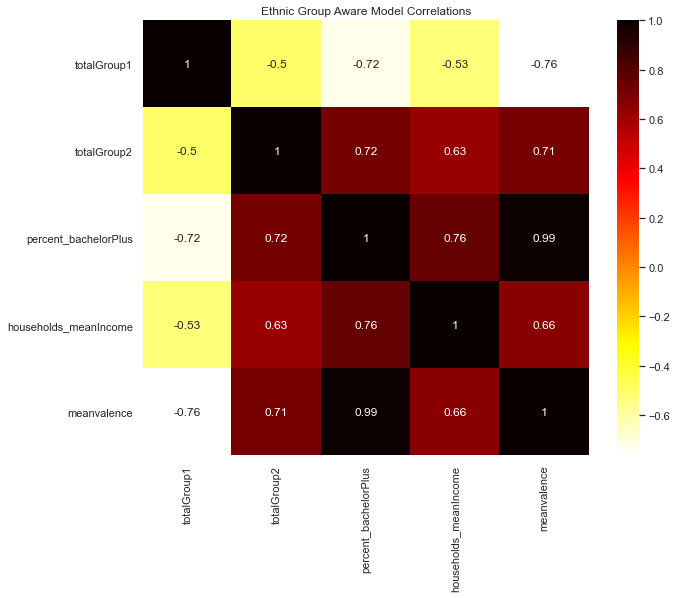

In [26]:
## corrplot
plt.title("Ethnic Group Aware Model Correlations")
sns.set(rc={'figure.figsize':(8,6)})
sns.heatmap(pred_results.corr(), annot=True, cmap="hot_r")
plt.savefig('../images/heatmap_2_ps4.png')

In [27]:
## Filter valence
pred_results.describe()

,totalGroup1,totalGroup2,percent_bachelorPlus,households_meanIncome,meanvalence
count,2021.000000,2021.000000,2021.000000,2021.000000,2021.000000
mean,0.271349,0.156175,0.328084,0.170923,0.390239
std,0.178384,0.155275,0.232344,0.085107,0.025842
min,0.001510,0.000000,0.000000,0.000000,0.351355
25%,0.121141,0.027159,0.133017,0.107948,0.368301
50%,0.249329,0.099865,0.270784,0.151046,0.384306
75%,0.397315,0.252868,0.485748,0.213206,0.408595
max,0.816611,0.659582,1.000000,0.525236,0.472585


In [28]:
## Scale the threshld 5.8 to 0.39
pred_results_filter = pred_results[pred_results['meanvalence'] >= 0.39]
pred_results_filter.describe()

,totalGroup1,totalGroup2,percent_bachelorPlus,households_meanIncome,meanvalence
count,879.000000,879.000000,879.000000,879.000000,879.000000
mean,0.132825,0.269728,0.549957,0.227608,0.415212
std,0.086700,0.153468,0.167040,0.090182,0.017702
min,0.001846,0.003036,0.260095,0.018591,0.390070
25%,0.064010,0.148617,0.403800,0.163992,0.400255
50%,0.118289,0.262483,0.532067,0.215797,0.412822
75%,0.180789,0.373735,0.673397,0.278185,0.428226
max,0.466107,0.659582,1.000000,0.525236,0.472585


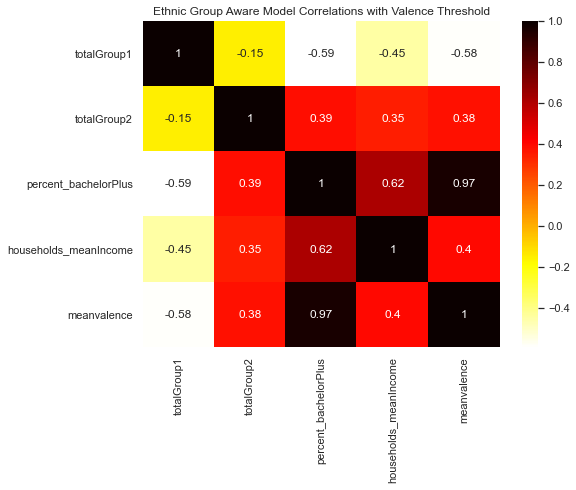

In [29]:
## Any bias to totalGroup1 or 2 after filtering by the threshold?
## corrplot
plt.title("Ethnic Group Aware Model Correlations with Valence Threshold")
sns.set(rc={'figure.figsize':(8,6)})

sns.heatmap(pred_results_filter.corr(), annot=True, cmap="hot_r")
plt.savefig('../images/heatmap_2_threshold_ps4.png')

## Ethnic Group Blind Model

3. Ethnic Group Blind Model (Prediction Model II) – Build a linear regression model
without using totalGroup1 and totalGroup2 as predictors, on a percentage of the data
provided. Predict the valence on the entire dataset. Analyze fairness of predicted valence
by comparing the correlations and scatterplots of Group Blind Model with Ground Truth
Model. Report your observations on the comparison. Does hiding these protected variables
change the bias identified in the previous model change here? Describe either way.

In [39]:
## Transformation Pipeline
df4 = df2.drop(['meanvalence', "totalGroup1", "totalGroup2"], axis=1)
# df4.head()

## Split in train/test/valid
X = df4.to_numpy()
y = df2['meanvalence'].to_numpy()
print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

## OLS Linear Reg Model - using sm
X_train_df = pd.DataFrame(X_train, columns=df4.columns)

# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model_blind = sm.OLS(y_train, X0_train).fit()
model_blind.summary()

(2021, 2) (2021,)
(1616, 2) (405, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.199
Method:                 Least Squares   F-statistic:                     202.0
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           5.23e-79
Time:                        14:16:04   Log-Likelihood:                 2515.0
No. Observations:                1616   AIC:                            -5024.
Df Residuals:                    1613   BIC:                            -5008.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.3595      0.003    125.645      0.000       0.354       0.365
percent_bachelorPlus      0.1285      0.009     15.058      0.000       0.112       0.145
households_meanIncome    -0.0665      0.023     -2.861      0.004      -0.112      -0.021
==============================================================================
Omnibus:                       41.888   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               62.595
Skew:                           0.254   Prob(JB):                     2.56e-14
Kurtosis:                       3.819   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [40]:
## Predict on ALL values (including training set)

X_df = pd.DataFrame(X, columns=df4.columns)
X0_df = sm.add_constant(X_df)
y_pred_blind = model_blind.predict(X0_df)

## get RMSE
# rmse = sm.tools.eval_measures.rmse(y_test, y_pred)
rmse = sm.tools.eval_measures.rmse(y, y_pred_blind)
print("RMSE", round(rmse,4))

RMSE 0.0506


In [42]:
# Get original columns back and concat to the group blind model results

pred_results_blind = pd.concat([df3, y_pred_blind], axis=1)
pred_results_blind = pred_results_blind.rename(columns={0: 'meanvalence'})
pred_results_blind.head()

,totalGroup1,totalGroup2,percent_bachelorPlus,households_meanIncome,meanvalence
0,0.206040,0.391026,0.230404,0.158403,0.378537
1,0.048322,0.366734,0.323040,0.294734,0.381367
2,0.405705,0.350371,0.197150,0.120171,0.376808
3,0.082718,0.230938,0.235154,0.113292,0.382149
4,0.058557,0.525472,0.368171,0.216570,0.392368


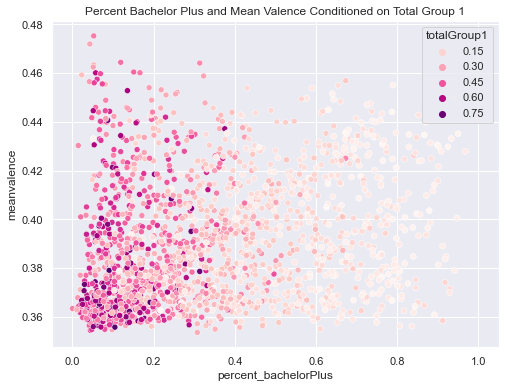

In [43]:
# scatterplot of valence and perc bp
plt.title('Percent Bachelor Plus and Mean Valence Conditioned on Total Group 1')
sns.scatterplot(data=pred_results_blind, x="percent_bachelorPlus", y="meanvalence", hue="totalGroup1", palette='RdPu')
plt.savefig('../images/scatter_1_ethnic_blind_ps4.png')

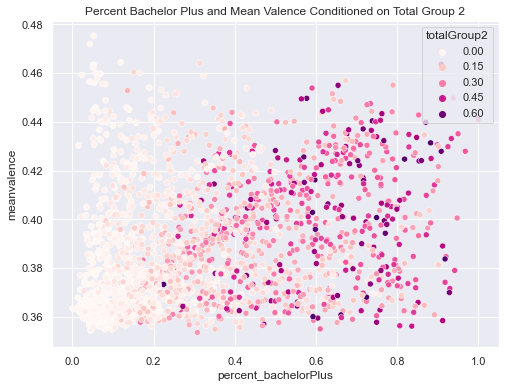

In [44]:
plt.title('Percent Bachelor Plus and Mean Valence Conditioned on Total Group 2')
sns.scatterplot(data=pred_results_blind, x="percent_bachelorPlus", y="meanvalence", hue="totalGroup2", palette='RdPu')
plt.savefig('../images/scatter_2_ethnic_blind_ps4.png')

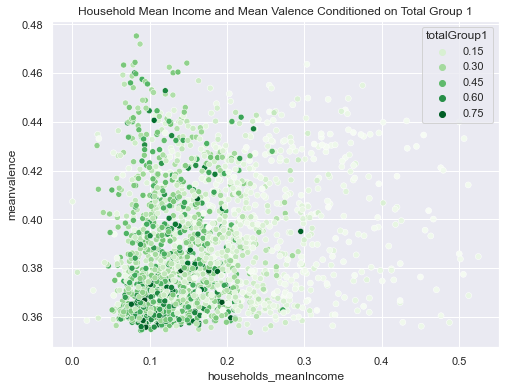

In [45]:
# scatterplot of valence and households mean income
plt.title('Household Mean Income and Mean Valence Conditioned on Total Group 1')
sns.scatterplot(data=pred_results_blind, x='households_meanIncome', y="meanvalence", hue="totalGroup1", palette='Greens')
plt.savefig('../images/scatter_3_ethnic_blind_ps4.png')

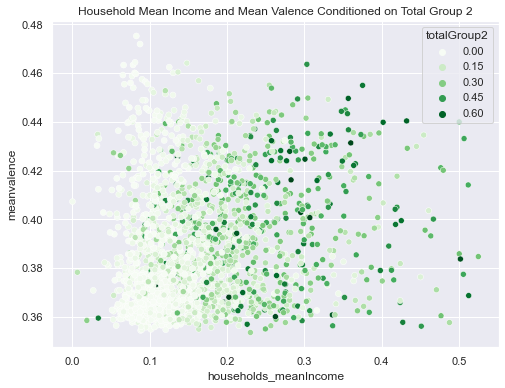

In [46]:
plt.title('Household Mean Income and Mean Valence Conditioned on Total Group 2')
sns.scatterplot(data=pred_results_blind, x='households_meanIncome', y="meanvalence", hue="totalGroup2", palette='Greens')
plt.savefig('../images/scatter_4_ethnic_blind_ps4.png')

## Fair Model

4. Fair Model – Our R&D team has published a paper on debiasing linear models (available
at: https://arxiv.org/pdf/1910.12854.pdf). On the basis of this work, we have written two
helper functions that you have to use in order to debias the outcome variable. The python
file consisting of these helper functions are available in fair_var.py.

In [ ]:
def gen_latent_fast(df0, prot_col, tar_col):
    """
    generate a representation for target column which is independent from
    any columns in prot_col
    df0: a data frame
    prot_col: list of strings, the protected columns
    tar_col: string, the target (outcome) column
    """
    df = df0.copy()
    for column in df.columns:
        df[column] = df[column] - df[column].mean()
    df_protect = df[prot_col]
    dfv_protect = df_protect.values
    dfv_target = df[tar_col].values
    base_protect = scipy.linalg.orth(dfv_protect)
    for i in range(base_protect.shape[1]):
        #print(base_protect[:,i].shape)
        dfv_target = dfv_target - np.inner(dfv_target, base_protect[:,i])*base_protect[:,i]
    return dfv_target

def gen_latent_nonparam_regula(df0, prot_col, tar_col, lbd):
    """
    generate a fair representation at a certain level define by lbd
    df0: a data frame
    prot_col: list of strings, the protected columns
    tar_col: string, the target (outcome) column
    lbd: float number between 0 and 1, 0 means totally fair; 1 means same as outcome
    """

    dfv_target = df0[tar_col].values
    dfv_mean = df0[tar_col].mean()
    dfv_target = dfv_target - dfv_mean

    latent0 = gen_latent_fast(df0, prot_col, tar_col)

    return latent0 + lbd*(dfv_target - latent0)

In [61]:
df2.columns

Index(['totalGroup1', 'totalGroup2', 'percent_bachelorPlus', 'meanvalence',
       'households_meanIncome'],
      dtype='object')

In [76]:
# df2 is our df
cols_to_convert = ['percent_bachelorPlus', 'meanvalence', 'households_meanIncome']
prot_col = ["totalGroup1", "totalGroup2"]

new_cols = []

for c in cols_to_convert:
    c_new = gen_latent_fast(df0=df2, prot_col=prot_col, tar_col=c)
#     c_new_t = np.transpose(c_new)
    new_cols.append(c_new)

In [82]:
# pd.DataFrame(new_cols, axis=1)
# np.concatenate(new_cols, axis=0).shape
res1 = np.vstack(new_cols)
res2 = np.transpose(res1)
res_df = pd.DataFrame(res2, columns = cols_to_convert)
res_df.head()

,percent_bachelorPlus,meanvalence,households_meanIncome
0,-0.308220,-0.002259,-0.083488
1,-0.297128,0.041584,0.037735
2,-0.186702,-0.115038,-0.083725
3,-0.265391,-0.095932,-0.103131
4,-0.360144,-0.120409,-0.080975


In [83]:
## Transformation Pipeline
df5 = res_df.drop(['meanvalence'], axis=1)

## Split in train/test/valid
X = df5.to_numpy()
y = res_df['meanvalence'].to_numpy()

print(X.shape, y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)
print(X_train.shape, X_test.shape)

## OLS Linear Reg Model - using sm
X_train_df = pd.DataFrame(X_train, columns=df5.columns)

# X_train_df.head()
X0_train = sm.add_constant(X_train_df)
model = sm.OLS(y_train, X0_train).fit()
model.summary()

(2021, 2) (2021,)
(1616, 2) (405, 2)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.064
Method:                 Least Squares   F-statistic:                     55.89
Date:                Tue, 23 Mar 2021   Prob (F-statistic):           3.41e-24
Time:                        14:35:01   Log-Likelihood:                 2515.9
No. Observations:                1616   AIC:                            -5026.
Df Residuals:                    1613   BIC:                            -5010.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -0.0006      0.001     -0.478      0.632      -0.003       0.002
percent_bachelorPlus      0.1183      0.012     10.159      0.000       0.095       0.141
households_meanIncome    -0.0662      0.024     -2.798      0.005      -0.113      -0.020
==============================================================================
Omnibus:                       41.173   Durbin-Watson:                   2.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.214
Skew:                           0.252   Prob(JB):                     5.10e-14
Kurtosis:                       3.809   Cond. No.                         19.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [84]:
## Predict on ALL values (including training set)

X_df = pd.DataFrame(X, columns=df5.columns)
X0_df = sm.add_constant(X_df)
y_pred = model.predict(X0_df)

## get RMSE
# rmse = sm.tools.eval_measures.rmse(y_test, y_pred)
rmse = sm.tools.eval_measures.rmse(y, y_pred)
print("RMSE", round(rmse,4))

RMSE 0.0505


In [91]:
# Get original columns back and concat to the group blind model results

pred_results = pd.concat([df2[["totalGroup1", "totalGroup2"]], df5, y_pred], axis=1)
pred_results = pred_results.rename(columns={0: 'meanvalence'})
pred_results.head()

,totalGroup1,totalGroup2,percent_bachelorPlus,households_meanIncome,meanvalence
0,0.206040,0.391026,-0.308220,-0.083488,-0.031532
1,0.048322,0.366734,-0.297128,0.037735,-0.038243
2,0.405705,0.350371,-0.186702,-0.083725,-0.017145
3,0.082718,0.230938,-0.265391,-0.103131,-0.025167
4,0.058557,0.525472,-0.360144,-0.080975,-0.037838


ValueError: Could not interpret value `totalGroup1` for parameter `hue`

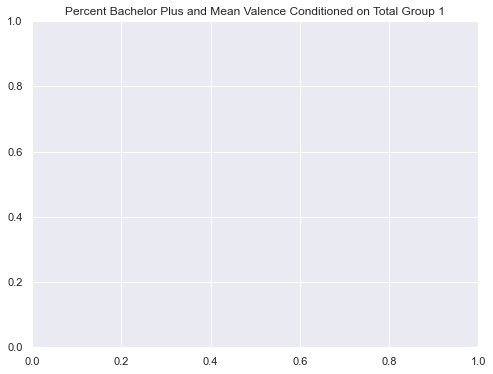

In [87]:
# scatterplot of valence and perc bp
plt.title('Percent Bachelor Plus and Mean Valence Conditioned on Total Group 1')
sns.scatterplot(data=pred_results, x="percent_bachelorPlus", y="meanvalence", hue="totalGroup1", palette='RdPu')
plt.savefig('../images/scatter_1_ethnic_blind_ps4.png')